In [1]:
!pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
import cv2

from imgaug import augmenters as iaa
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras import utils

2024-02-21 12:24:57.381523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:24:57.381659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:24:57.531292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_set=np.load("/kaggle/input/galaxy-dataset/image_set.npy")

label_set=np.load('/kaggle/input/galaxy-dataset/label_set.npy')

In [4]:
features = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 'Disk, Edge-on, Boxy Bulge', 'Disk, Face-on, Tight Spiral']

In [5]:
df = pd.DataFrame(data=label_set)

counts = df.value_counts().sort_index()
print(counts)

0
0    3461
1    6997
2    6292
4    1534
7    1121
Name: count, dtype: int64


/tmp/ipykernel_25/2964640414.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_set, rotation=90)


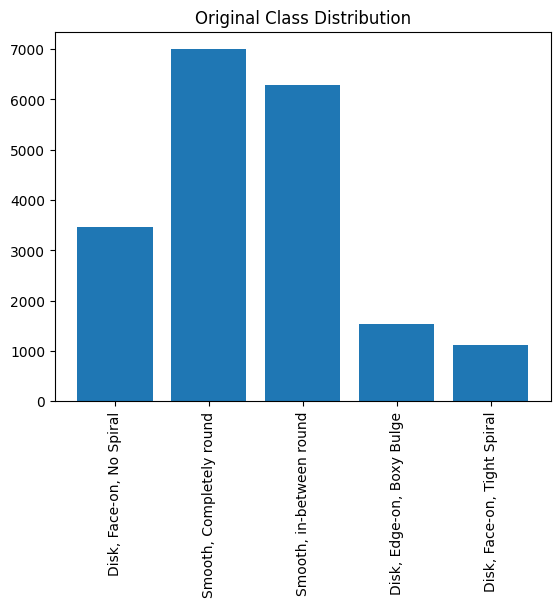

In [6]:
def class_distribution(x, y, label_set):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(label_set, rotation=90)
    plt.title("Original Class Distribution")
    plt.show()
    
class_distribution(features, counts, features)

In [7]:
image_set.shape

(19405, 69, 69, 3)

In [8]:
image_set = image_set/255.0

In [9]:
def rgb_to_gray(image):
    gray_image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    return gray_image

In [10]:
gray_images = rgb_to_gray(image_set)

In [11]:
gray_images[0].shape

(69, 69)

Text(0.5, 1.0, 'Smooth, in-between round')

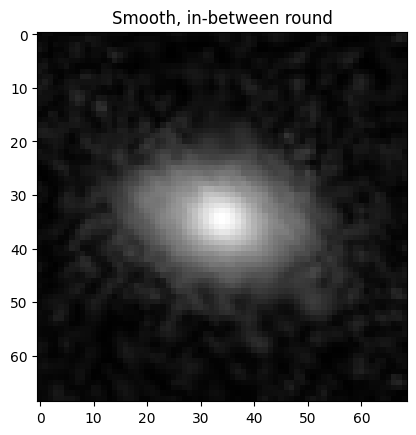

In [12]:
plt.imshow(gray_images[15098], cmap= 'gray')
plt.title(features[label_set[15098]])

In [13]:
images_train, images_test, labels_train, labels_test = train_test_split(gray_images, label_set, test_size=0.2)

In [14]:
df_train = pd.DataFrame(data=labels_train)

counts = df_train.value_counts().sort_index()
print(counts)

0
0    2784
1    5595
2    5034
4    1206
7     905
Name: count, dtype: int64


In [15]:
type(images_train)

numpy.ndarray

In [16]:
# Create a dictionary to store the count of images for each label
label_counts = {}
for label in np.unique(labels_train):
    label_counts[label] = np.sum(labels_train == label)

# Augmentation parameters
augmentation_params = {
    "flip_horizontal": True,
    "rotate_range": (-10, 10)
}

augmented_images = []
augmented_labels = []

# Iterate over labels and augment images for labels with less than 2000 images
for label, count in label_counts.items():
    if count < 2000:
        # Calculate how many augmented images to create
        num_augmented_images = np.random.randint(2000 - count, 2201 - count)
        
        # Augment images for this label
        indices = np.where(labels_train == label)[0]
        selected_images = images_train[indices]
        seq = iaa.Sequential([
            iaa.Fliplr(0.5) if augmentation_params["flip_horizontal"] else iaa.Noop(),
            iaa.Affine(rotate=augmentation_params["rotate_range"])
        ])
        augmented = seq.augment_images(selected_images)
        
        # Append augmented images and labels
        augmented_images.extend(augmented[:num_augmented_images])
        augmented_labels.extend([label] * num_augmented_images)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

images_train_augmented = np.concatenate([images_train, augmented_images])
labels_train_augmented = np.concatenate([labels_train, augmented_labels])

shuffled_indices = np.random.permutation(len(images_train_augmented))
images_train_augmented = images_train_augmented[shuffled_indices]
labels_train_augmented = labels_train_augmented[shuffled_indices]

np.save("images_train_augmented.npy", images_train_augmented)
np.save("labels_train_augmented.npy", labels_train_augmented)


In [17]:
df_train_augmented = pd.DataFrame(data=labels_train_augmented)

counts = df_train_augmented.value_counts().sort_index()
print(counts)

0
0    2784
1    5595
2    5034
4    2071
7    1810
Name: count, dtype: int64


In [18]:
# Reshape the images into 2D (samples, height * width)
n_samples, height, width = images_train_augmented.shape
images_train_augmented_reshaped = images_train_augmented.reshape(n_samples, height * width)

# Create a RandomUnderSampler instance
under_sampler = RandomUnderSampler(sampling_strategy={label: 2500 for label, count in zip(*np.unique(labels_train_augmented, return_counts=True)) if count > 5000})

images_train_undersampled_reshaped, labels_train_undersampled = under_sampler.fit_resample(images_train_augmented_reshaped, labels_train_augmented)

images_train_undersampled = images_train_undersampled_reshaped.reshape(-1, height, width)

# Shuffle the undersampled data
images_train_undersampled, labels_train_undersampled = shuffle(images_train_undersampled, labels_train_undersampled)

np.save("images_train_undersampled.npy", images_train_undersampled)
np.save("labels_train_undersampled.npy", labels_train_undersampled)


In [19]:
df_train_undersampled = pd.DataFrame(labels_train_undersampled)

counts = df_train_undersampled.value_counts().sort_index()
print(counts)

0
0    2784
1    2500
2    2500
4    2071
7    1810
Name: count, dtype: int64


/tmp/ipykernel_25/2894099714.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


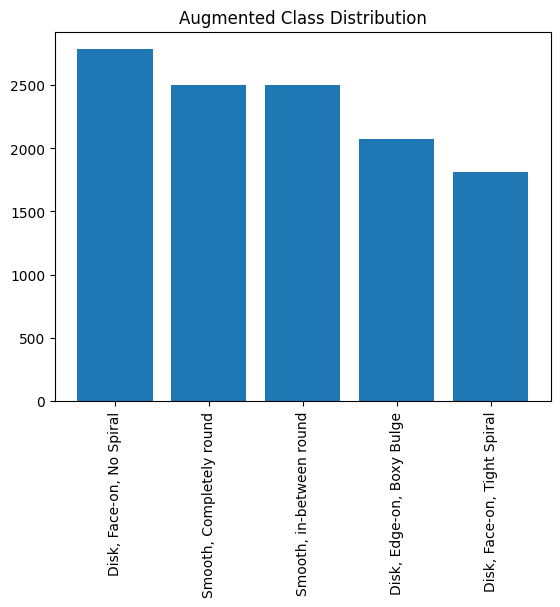

In [20]:
def class_distribution(x, y, labels):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(labels, rotation=90)
    plt.title("Augmented Class Distribution")
    plt.show()
    
class_distribution(features, counts, features)

In [21]:
def build_model(hp):  
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(69, 69, 1)
        ),
        keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=48, max_value=80, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float('l2_conv_1', min_value=1e-6, max_value=1e-2, sampling='log'))
        ),
        keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        
        keras.layers.Conv2D(
            filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=128),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5, 7]),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float('l2_conv_1', min_value=1e-6, max_value=1e-2, sampling='log'))
        ),
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float('l2_conv_1', min_value=1e-6, max_value=1e-2, sampling='log'))
        ),
        
        keras.layers.Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.05)),
        
        keras.layers.Dense(10, activation='softmax')
    ])
  
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=(1e-1, 1e-3))),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  
    return model

In [22]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import regularizers

/tmp/ipykernel_25/736546661.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [23]:
tuner_search=RandomSearch(build_model,
                          objective= 'val_accuracy',
                          max_trials=5,directory='output',project_name="Galaxy Classification")

In [24]:
tuner_search.search(images_train_undersampled,labels_train_undersampled,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.23307625949382782

Best val_accuracy So Far: 0.5689802765846252
Total elapsed time: 00h 01m 51s


In [25]:
model=tuner_search.get_best_models(num_models=1)[0]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 48)        480       
                                                                 
 dropout (Dropout)           (None, 67, 67, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 80)        96080     
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 80)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        23072     
                                                                 
 flatten (Flatten)           (None, 119072)            0         
                                                                 
 dense (Dense)               (None, 64)                7

In [27]:
model.fit(images_train_undersampled, labels_train_undersampled, epochs=20, validation_data=(images_test, labels_test))

Epoch 1/20
365/365 [==============================] - 9s 21ms/step - loss: 1.2378 - accuracy: 0.4565 - val_loss: 1.2629 - val_accuracy: 0.4295
Epoch 2/20
365/365 [==============================] - 7s 18ms/step - loss: 1.2789 - accuracy: 0.4453 - val_loss: 1.2538 - val_accuracy: 0.4447
Epoch 3/20
365/365 [==============================] - 7s 18ms/step - loss: 1.2175 - accuracy: 0.4580 - val_loss: 1.0781 - val_accuracy: 0.5648
Epoch 4/20
365/365 [==============================] - 7s 18ms/step - loss: 1.1925 - accuracy: 0.4776 - val_loss: 1.0715 - val_accuracy: 0.5627
Epoch 5/20
365/365 [==============================] - 7s 18ms/step - loss: 1.1869 - accuracy: 0.4854 - val_loss: 0.9952 - val_accuracy: 0.5710
Epoch 6/20
365/365 [==============================] - 7s 18ms/step - loss: 1.1730 - accuracy: 0.4841 - val_loss: 1.0970 - val_accuracy: 0.5720
Epoch 7/20
365/365 [==============================] - 7s 18ms/step - loss: 1.1493 - accuracy: 0.5017 - val_loss: 1.0852 - val_accuracy: 0.5050

In [28]:
predictions = model.predict(images_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = labels_test

122/122 [==============================] - 1s 4ms/step


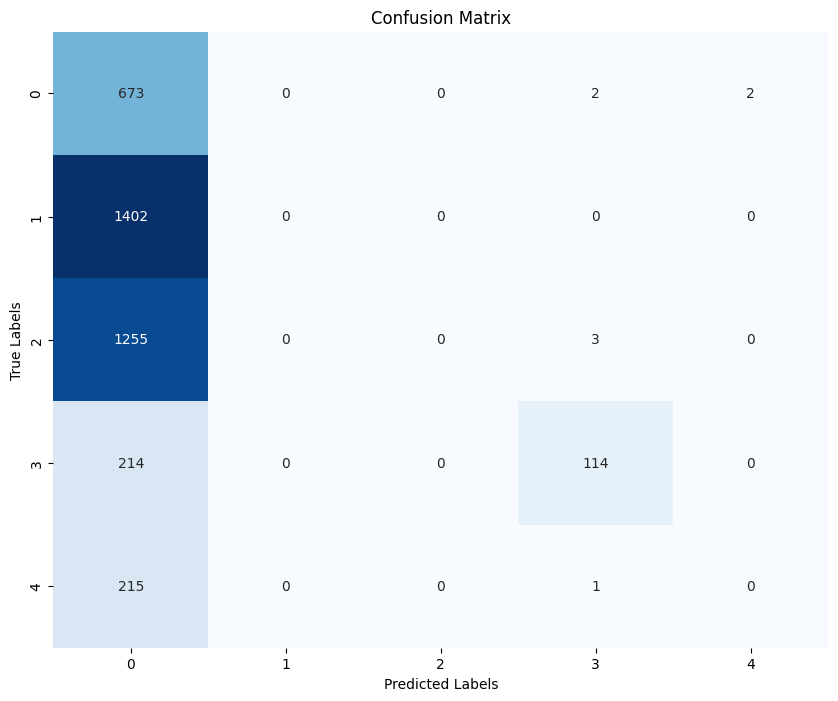

In [29]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Generate classification report
report = classification_report(labels_test, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.18      0.99      0.30       677
           1       0.00      0.00      0.00      1402
           2       0.00      0.00      0.00      1258
           4       0.95      0.35      0.51       328
           7       0.00      0.00      0.00       216

    accuracy                           0.20      3881
   macro avg       0.23      0.27      0.16      3881
weighted avg       0.11      0.20      0.10      3881



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model.save("Galaxy Classification")